In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nba-games/players.csv
/kaggle/input/nba-games/teams.csv
/kaggle/input/nba-games/ranking.csv
/kaggle/input/nba-games/games_details.csv
/kaggle/input/nba-games/games.csv


# **Objetivo**:

<font size="4">- Conocer si se ganaron más partidos de local o de visitante.</font>

<font size="4">- Qué equipos hicieron la mayor cantidad de puntos, de local y visitante.</font>

<font size="4">- Cuántos partidos ganaron los distintos equipos de local y visitante.</font>

<font size="4">- Cómo se han comportado los puntos anotados a lo largo de los años.</font>

<font size="4">- Contra qué equipos se ha ganado más de local y visitante.</font>

In [2]:
#Cargo los archivos
games = pd.read_csv('/kaggle/input/nba-games/games.csv')
games.head(3)

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,Final,1610612740,1610612759,2022,1610612740,126.0,0.484,0.926,...,25.0,46.0,1610612759,117.0,0.478,0.815,0.321,23.0,44.0,1
1,2022-12-22,22200478,Final,1610612762,1610612764,2022,1610612762,120.0,0.488,0.952,...,16.0,40.0,1610612764,112.0,0.561,0.765,0.333,20.0,37.0,1
2,2022-12-21,22200466,Final,1610612739,1610612749,2022,1610612739,114.0,0.482,0.786,...,22.0,37.0,1610612749,106.0,0.470,0.682,0.433,20.0,46.0,1


In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26651 entries, 0 to 26650
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GAME_DATE_EST     26651 non-null  object 
 1   GAME_ID           26651 non-null  int64  
 2   GAME_STATUS_TEXT  26651 non-null  object 
 3   HOME_TEAM_ID      26651 non-null  int64  
 4   VISITOR_TEAM_ID   26651 non-null  int64  
 5   SEASON            26651 non-null  int64  
 6   TEAM_ID_home      26651 non-null  int64  
 7   PTS_home          26552 non-null  float64
 8   FG_PCT_home       26552 non-null  float64
 9   FT_PCT_home       26552 non-null  float64
 10  FG3_PCT_home      26552 non-null  float64
 11  AST_home          26552 non-null  float64
 12  REB_home          26552 non-null  float64
 13  TEAM_ID_away      26651 non-null  int64  
 14  PTS_away          26552 non-null  float64
 15  FG_PCT_away       26552 non-null  float64
 16  FT_PCT_away       26552 non-null  float6

In [4]:
#Filtro las columnas que voy a utilizar
games = games[['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT','TEAM_ID_home',
              'TEAM_ID_away','PTS_home','PTS_away', 'HOME_TEAM_WINS']]
games.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,TEAM_ID_home,TEAM_ID_away,PTS_home,PTS_away,HOME_TEAM_WINS
0,2022-12-22,22200477,Final,1610612740,1610612759,126.0,117.0,1
1,2022-12-22,22200478,Final,1610612762,1610612764,120.0,112.0,1
2,2022-12-21,22200466,Final,1610612739,1610612749,114.0,106.0,1
3,2022-12-21,22200467,Final,1610612755,1610612765,113.0,93.0,1
4,2022-12-21,22200468,Final,1610612737,1610612741,108.0,110.0,0


In [5]:
#Cambio el tipo de dato de la fecha
games.loc[:, 'GAME_DATE_EST'] = pd.to_datetime(games['GAME_DATE_EST'], format='%Y-%m-%d')

In [6]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26651 entries, 0 to 26650
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GAME_DATE_EST     26651 non-null  object 
 1   GAME_ID           26651 non-null  int64  
 2   GAME_STATUS_TEXT  26651 non-null  object 
 3   TEAM_ID_home      26651 non-null  int64  
 4   TEAM_ID_away      26651 non-null  int64  
 5   PTS_home          26552 non-null  float64
 6   PTS_away          26552 non-null  float64
 7   HOME_TEAM_WINS    26651 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 1.6+ MB


In [7]:
#Agrego la columna en la que se va a almacenar el año en que se jugó el partido
# Convertir la columna 'GAME_DATE_EST' a datetime si aún no lo está
games['GAME_DATE_EST'] = pd.to_datetime(games['GAME_DATE_EST'])

# Agregar la columna 'year' para almacenar el año en que se jugó el partido
games['year'] = games['GAME_DATE_EST'].dt.year
games.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,TEAM_ID_home,TEAM_ID_away,PTS_home,PTS_away,HOME_TEAM_WINS,year
0,2022-12-22,22200477,Final,1610612740,1610612759,126.0,117.0,1,2022
1,2022-12-22,22200478,Final,1610612762,1610612764,120.0,112.0,1,2022
2,2022-12-21,22200466,Final,1610612739,1610612749,114.0,106.0,1,2022
3,2022-12-21,22200467,Final,1610612755,1610612765,113.0,93.0,1,2022
4,2022-12-21,22200468,Final,1610612737,1610612741,108.0,110.0,0,2022


In [8]:
#Cargamos los equipos
teams = pd.read_csv('/kaggle/input/nba-games/teams.csv')
teams.head()

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,0,1610612737,1949,2019,ATL,Hawks,1949,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Lloyd Pierce,Erie Bayhawks
1,0,1610612738,1946,2019,BOS,Celtics,1946,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws
2,0,1610612740,2002,2019,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
3,0,1610612741,1966,2019,CHI,Bulls,1966,Chicago,United Center,21711.0,Jerry Reinsdorf,Gar Forman,Jim Boylen,Windy City Bulls
4,0,1610612742,1980,2019,DAL,Mavericks,1980,Dallas,American Airlines Center,19200.0,Mark Cuban,Donnie Nelson,Rick Carlisle,Texas Legends


In [9]:
#Nos quedamos con las columnas que vamos a utilizar
teams = teams[['TEAM_ID','CITY','NICKNAME']]
teams.head()

,TEAM_ID,CITY,NICKNAME
0,1610612737,Atlanta,Hawks
1,1610612738,Boston,Celtics
2,1610612740,New Orleans,Pelicans
3,1610612741,Chicago,Bulls
4,1610612742,Dallas,Mavericks


In [10]:
#Fusionamos las columnas para un mejor análisis sobre los equipos que jugaron de local
home_games = pd.merge(games,teams,left_on='TEAM_ID_home',right_on='TEAM_ID',how='inner')
home_games.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,TEAM_ID_home,TEAM_ID_away,PTS_home,PTS_away,HOME_TEAM_WINS,year,TEAM_ID,CITY,NICKNAME
0,2022-12-22,22200477,Final,1610612740,1610612759,126.0,117.0,1,2022,1610612740,New Orleans,Pelicans
1,2022-12-22,22200478,Final,1610612762,1610612764,120.0,112.0,1,2022,1610612762,Utah,Jazz
2,2022-12-21,22200466,Final,1610612739,1610612749,114.0,106.0,1,2022,1610612739,Cleveland,Cavaliers
3,2022-12-21,22200467,Final,1610612755,1610612765,113.0,93.0,1,2022,1610612755,Philadelphia,76ers
4,2022-12-21,22200468,Final,1610612737,1610612741,108.0,110.0,0,2022,1610612737,Atlanta,Hawks


In [11]:
#Renombramos las columnas
home_games = home_games.rename(columns={
    'CITY': 'city_home',
    'NICKNAME': 'nickname_home'
})
home_games.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,TEAM_ID_home,TEAM_ID_away,PTS_home,PTS_away,HOME_TEAM_WINS,year,TEAM_ID,city_home,nickname_home
0,2022-12-22,22200477,Final,1610612740,1610612759,126.0,117.0,1,2022,1610612740,New Orleans,Pelicans
1,2022-12-22,22200478,Final,1610612762,1610612764,120.0,112.0,1,2022,1610612762,Utah,Jazz
2,2022-12-21,22200466,Final,1610612739,1610612749,114.0,106.0,1,2022,1610612739,Cleveland,Cavaliers
3,2022-12-21,22200467,Final,1610612755,1610612765,113.0,93.0,1,2022,1610612755,Philadelphia,76ers
4,2022-12-21,22200468,Final,1610612737,1610612741,108.0,110.0,0,2022,1610612737,Atlanta,Hawks


In [13]:
# Renombramos las columnas en el segundo DataFrame 'teams'
teams_rename = teams.rename(columns={'TEAM_ID': 'TEAM_ID_away', 'CITY': 'CITY_away', 'NICKNAME': 'NICKNAME_away'})

In [14]:
# Fusionamos las columnas para un mejor análisis sobre los equipos que jugaron de visitante
both_games = pd.merge(home_games, teams_rename, left_on='TEAM_ID_away', right_on='TEAM_ID_away', how='inner')
both_games.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,TEAM_ID_home,TEAM_ID_away,PTS_home,PTS_away,HOME_TEAM_WINS,year,TEAM_ID,city_home,nickname_home,CITY_away,NICKNAME_away
0,2022-12-22,22200477,Final,1610612740,1610612759,126.0,117.0,1,2022,1610612740,New Orleans,Pelicans,San Antonio,Spurs
1,2022-12-22,22200478,Final,1610612762,1610612764,120.0,112.0,1,2022,1610612762,Utah,Jazz,Washington,Wizards
2,2022-12-21,22200466,Final,1610612739,1610612749,114.0,106.0,1,2022,1610612739,Cleveland,Cavaliers,Milwaukee,Bucks
3,2022-12-21,22200467,Final,1610612755,1610612765,113.0,93.0,1,2022,1610612755,Philadelphia,76ers,Detroit,Pistons
4,2022-12-21,22200468,Final,1610612737,1610612741,108.0,110.0,0,2022,1610612737,Atlanta,Hawks,Chicago,Bulls


In [15]:
#Renombramos las columnas
both_games = both_games.rename(columns={
    'CITY': 'city_away',
    'NICKNAME': 'nickname_away'
})
both_games.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,TEAM_ID_home,TEAM_ID_away,PTS_home,PTS_away,HOME_TEAM_WINS,year,TEAM_ID,city_home,nickname_home,CITY_away,NICKNAME_away
0,2022-12-22,22200477,Final,1610612740,1610612759,126.0,117.0,1,2022,1610612740,New Orleans,Pelicans,San Antonio,Spurs
1,2022-12-22,22200478,Final,1610612762,1610612764,120.0,112.0,1,2022,1610612762,Utah,Jazz,Washington,Wizards
2,2022-12-21,22200466,Final,1610612739,1610612749,114.0,106.0,1,2022,1610612739,Cleveland,Cavaliers,Milwaukee,Bucks
3,2022-12-21,22200467,Final,1610612755,1610612765,113.0,93.0,1,2022,1610612755,Philadelphia,76ers,Detroit,Pistons
4,2022-12-21,22200468,Final,1610612737,1610612741,108.0,110.0,0,2022,1610612737,Atlanta,Hawks,Chicago,Bulls


In [16]:
#Modificamos games asignándole una copia de both_games para mejorarlo
games = both_games.copy()
games.columns = games.columns.str.lower()
games.head()

,game_date_est,game_id,game_status_text,team_id_home,team_id_away,pts_home,pts_away,home_team_wins,year,team_id,city_home,nickname_home,city_away,nickname_away
0,2022-12-22,22200477,Final,1610612740,1610612759,126.0,117.0,1,2022,1610612740,New Orleans,Pelicans,San Antonio,Spurs
1,2022-12-22,22200478,Final,1610612762,1610612764,120.0,112.0,1,2022,1610612762,Utah,Jazz,Washington,Wizards
2,2022-12-21,22200466,Final,1610612739,1610612749,114.0,106.0,1,2022,1610612739,Cleveland,Cavaliers,Milwaukee,Bucks
3,2022-12-21,22200467,Final,1610612755,1610612765,113.0,93.0,1,2022,1610612755,Philadelphia,76ers,Detroit,Pistons
4,2022-12-21,22200468,Final,1610612737,1610612741,108.0,110.0,0,2022,1610612737,Atlanta,Hawks,Chicago,Bulls


In [17]:
#Creo una nueva columna que describa la cantidad de puntos totales que se hicieron de local y visitante
games['total_points'] = games['pts_home'] + games['pts_away']
games.head()

,game_date_est,game_id,game_status_text,team_id_home,team_id_away,pts_home,pts_away,home_team_wins,year,team_id,city_home,nickname_home,city_away,nickname_away,total_points
0,2022-12-22,22200477,Final,1610612740,1610612759,126.0,117.0,1,2022,1610612740,New Orleans,Pelicans,San Antonio,Spurs,243.0
1,2022-12-22,22200478,Final,1610612762,1610612764,120.0,112.0,1,2022,1610612762,Utah,Jazz,Washington,Wizards,232.0
2,2022-12-21,22200466,Final,1610612739,1610612749,114.0,106.0,1,2022,1610612739,Cleveland,Cavaliers,Milwaukee,Bucks,220.0
3,2022-12-21,22200467,Final,1610612755,1610612765,113.0,93.0,1,2022,1610612755,Philadelphia,76ers,Detroit,Pistons,206.0
4,2022-12-21,22200468,Final,1610612737,1610612741,108.0,110.0,0,2022,1610612737,Atlanta,Hawks,Chicago,Bulls,218.0


In [18]:
#Ahora puedo conocer en qué partidos se hicieron más puntos
games.nlargest(n=5, columns='total_points')

,game_date_est,game_id,game_status_text,team_id_home,team_id_away,pts_home,pts_away,home_team_wins,year,team_id,city_home,nickname_home,city_away,nickname_away,total_points
20030,2019-03-01,21800928,Final,1610612737,1610612741,161.0,168.0,0,2019,1610612737,Atlanta,Hawks,Chicago,Bulls,329.0
14727,2006-12-07,20600271,Final,1610612751,1610612756,157.0,161.0,0,2006,1610612751,Brooklyn,Nets,Phoenix,Suns,318.0
19528,2019-10-30,21900061,Final,1610612764,1610612745,158.0,159.0,0,2019,1610612764,Washington,Wizards,Houston,Rockets,317.0
969,2022-02-25,22100899,Final,1610612764,1610612759,153.0,157.0,0,2022,1610612764,Washington,Wizards,San Antonio,Spurs,310.0
3349,2020-07-31,21901238,Final,1610612742,1610612745,149.0,153.0,0,2020,1610612742,Dallas,Mavericks,Houston,Rockets,302.0


In [19]:
#Ahora puedo conocer en qué partidos se hicieron menos puntos
games.nsmallest(n=5, columns='total_points')

,game_date_est,game_id,game_status_text,team_id_home,team_id_away,pts_home,pts_away,home_team_wins,year,team_id,city_home,nickname_home,city_away,nickname_away,total_points
13632,2007-10-19,10700072,Final,1610612738,1610612751,36.0,33.0,1,2007,1610612738,Boston,Celtics,Brooklyn,Nets,69.0
19275,2003-10-08,10300012,Final,1610612754,1610612741,62.0,58.0,1,2003,1610612754,Indiana,Pacers,Chicago,Bulls,120.0
17807,2004-11-09,20400049,Final,1610612751,1610612757,64.0,60.0,1,2004,1610612751,Brooklyn,Nets,Portland,Trail Blazers,124.0
16931,2005-03-13,20400927,Final,1610612765,1610612762,64.0,62.0,1,2005,1610612765,Detroit,Pistons,Utah,Jazz,126.0
19137,2003-11-01,20300031,Final,1610612750,1610612761,73.0,56.0,1,2003,1610612750,Minnesota,Timberwolves,Toronto,Raptors,129.0


# Gráficos

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
#Vemos cuántos partidos se ganaron de local y de visitante (1=locales, 0 = Visitantes)
total = games['home_team_wins'].value_counts()
total

home_team_wins
1    15645
0    11006
Name: count, dtype: int64

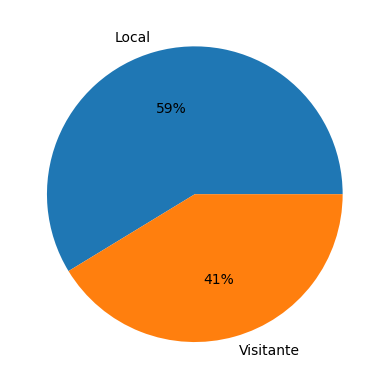

In [22]:
plt.pie(total.values, labels=['Local', 'Visitante'], autopct='%.0f%%')
plt.show()

/tmp/ipykernel_33/647331041.py:4: FutureWarning: The provided callable <function mean at 0x780bc06dc550> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  result = home_wins.groupby('nickname_home')['pts_home'].aggregate(np.mean).reset_index().sort_values('pts_home')


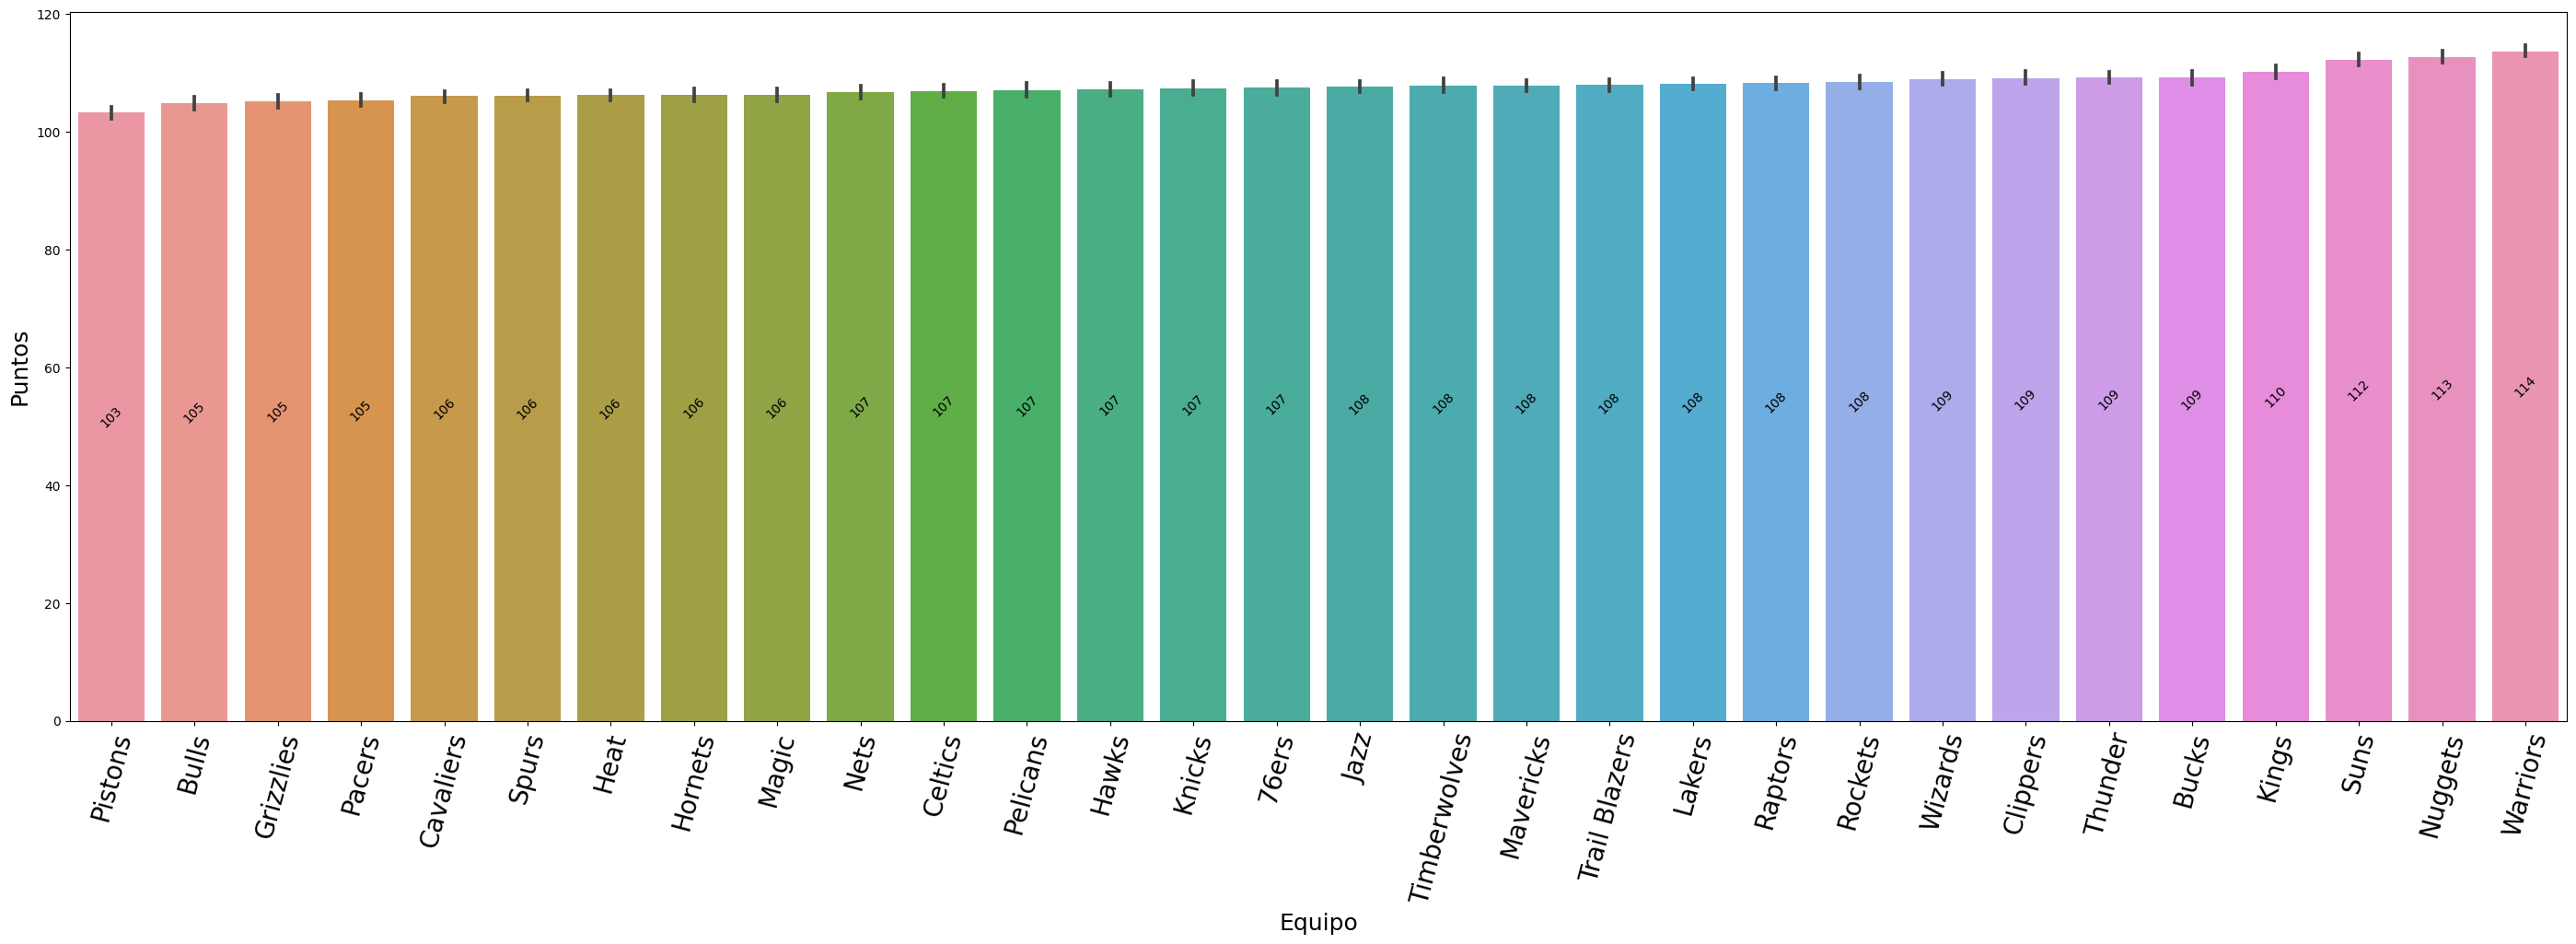

In [23]:
#Analizamos la cantidad de puntos por equipo cuando juegan de local 
plt.figure(figsize=(35,10))
home_wins = games[games['home_team_wins'] == 1]
result = home_wins.groupby('nickname_home')['pts_home'].aggregate(np.mean).reset_index().sort_values('pts_home')

ax = sns.barplot(data=home_wins, x='nickname_home', y='pts_home', order=result['nickname_home'] )
ax.bar_label(ax.containers[-1], fmt='%.0f', label_type='center', rotation=45 )
plt.xticks(rotation=75, fontsize=20)
plt.xlabel('Equipo', fontsize=18) 
plt.ylabel('Puntos', fontsize=18) 
plt.show()

/tmp/ipykernel_33/2435804540.py:4: FutureWarning: The provided callable <function mean at 0x780bc06dc550> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  result = away_wins.groupby('nickname_away')['pts_away'].aggregate(np.mean).reset_index().sort_values('pts_away')


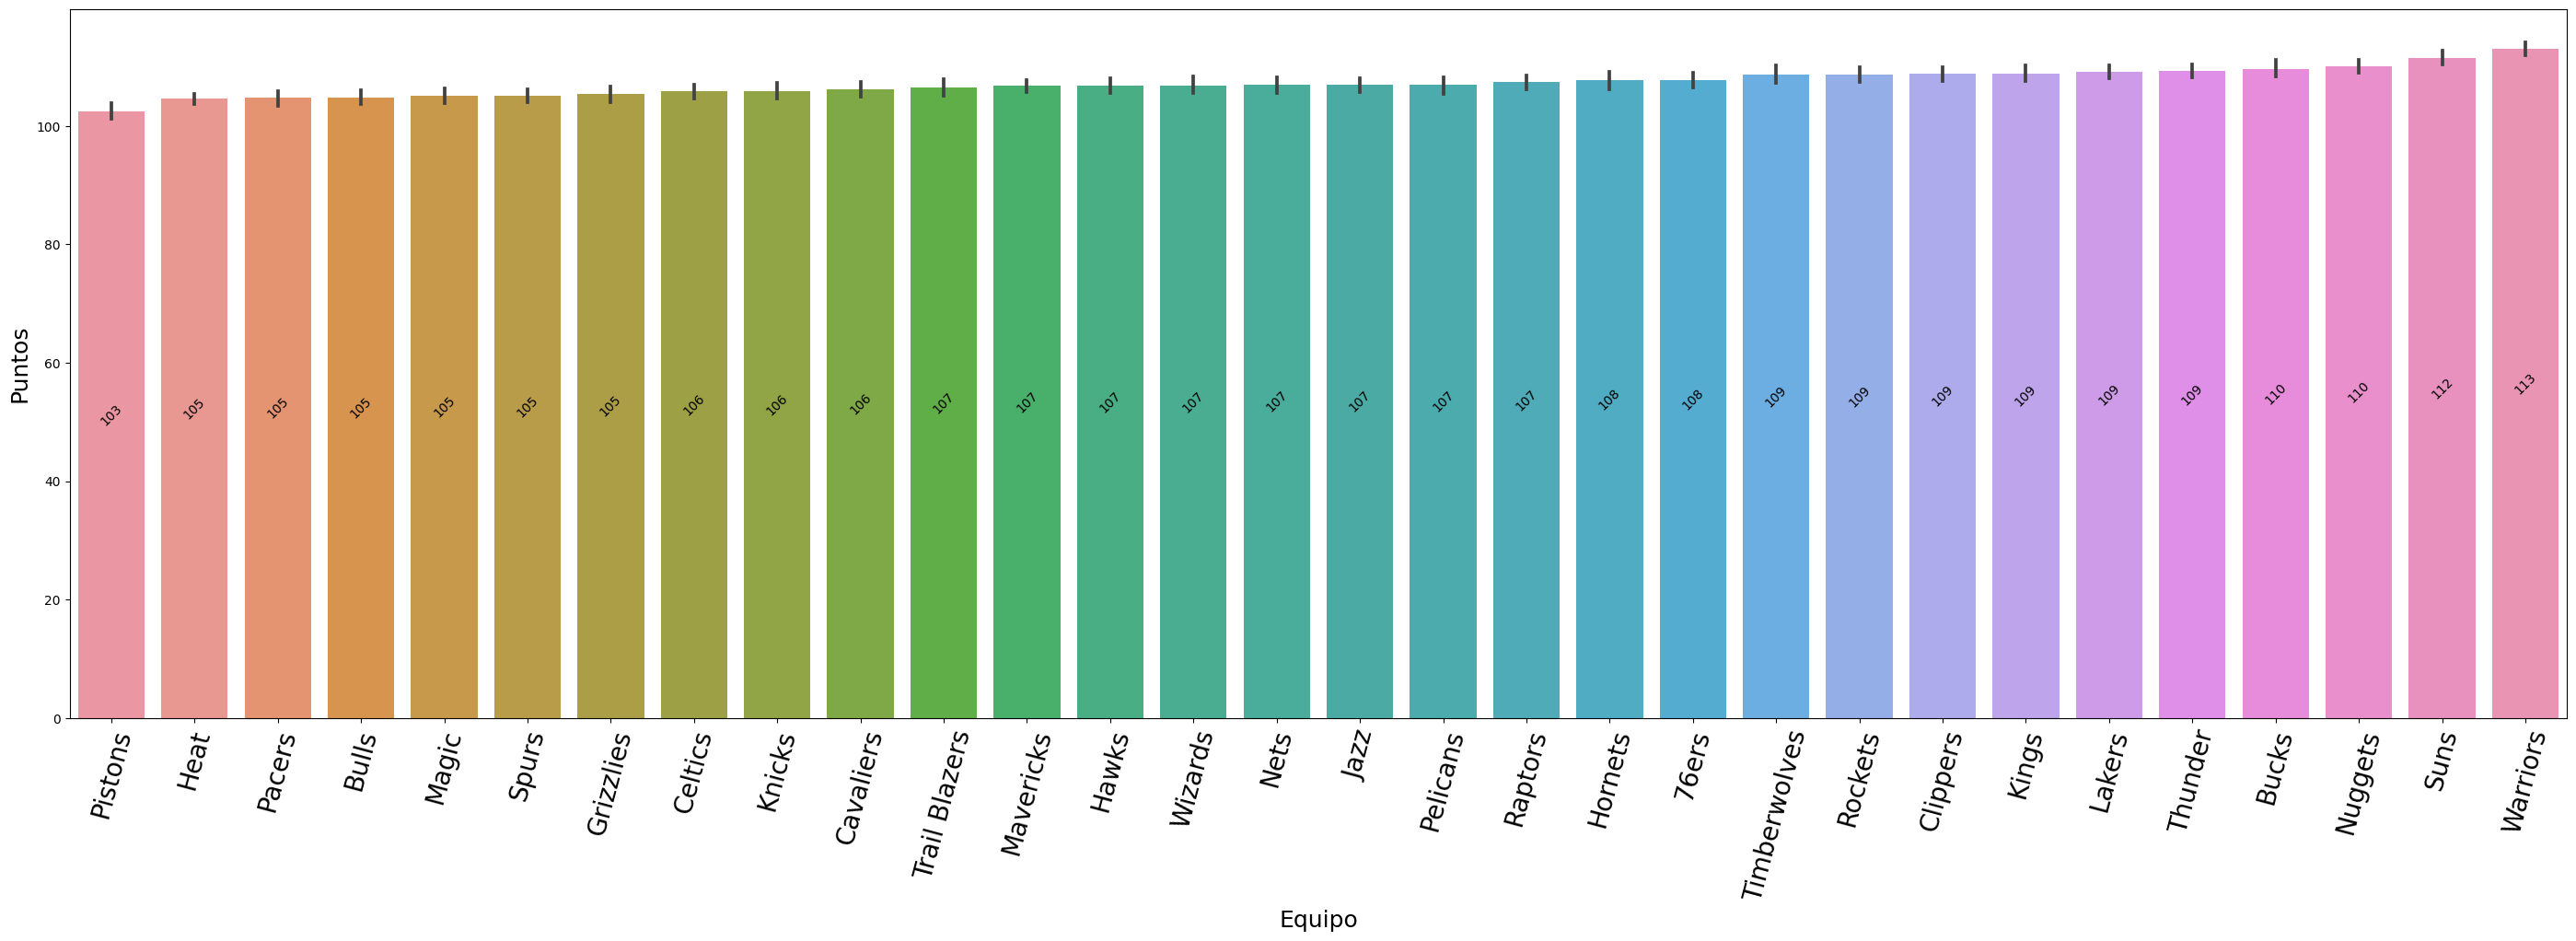

In [24]:
#Analizamos la cantidad de puntos por equipo cuando juegan de visitante 
plt.figure(figsize=(35,10))
away_wins = games[games['home_team_wins'] == 0]
result = away_wins.groupby('nickname_away')['pts_away'].aggregate(np.mean).reset_index().sort_values('pts_away')

ax = sns.barplot(data=away_wins, x='nickname_away', y='pts_away', order=result['nickname_away'] )
ax.bar_label(ax.containers[-1], fmt='%.0f', label_type='center', rotation=45 )
plt.xticks(rotation=75, fontsize=20)
plt.xlabel('Equipo', fontsize=18) 
plt.ylabel('Puntos', fontsize=18) 
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='total_points', ylabel='Count'>

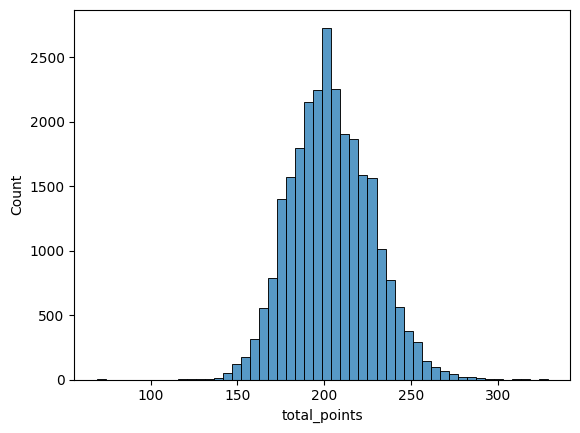

In [25]:
#Para saber el rango general de puntos por partido
sns.histplot(data=games, x='total_points', bins=50)

<Axes: xlabel='total_points'>

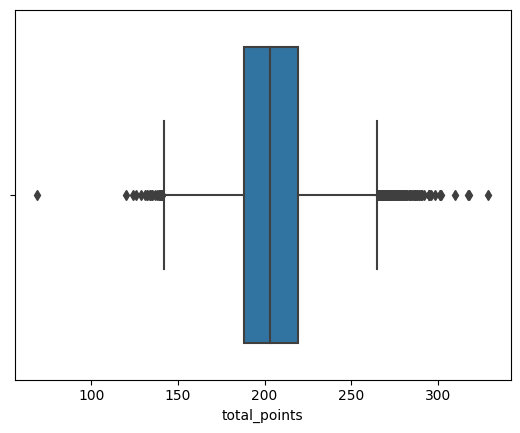

In [26]:
#Analizamos los puntos totales a lo largo de la historia en un partido
sns.boxplot(x=games['total_points'])

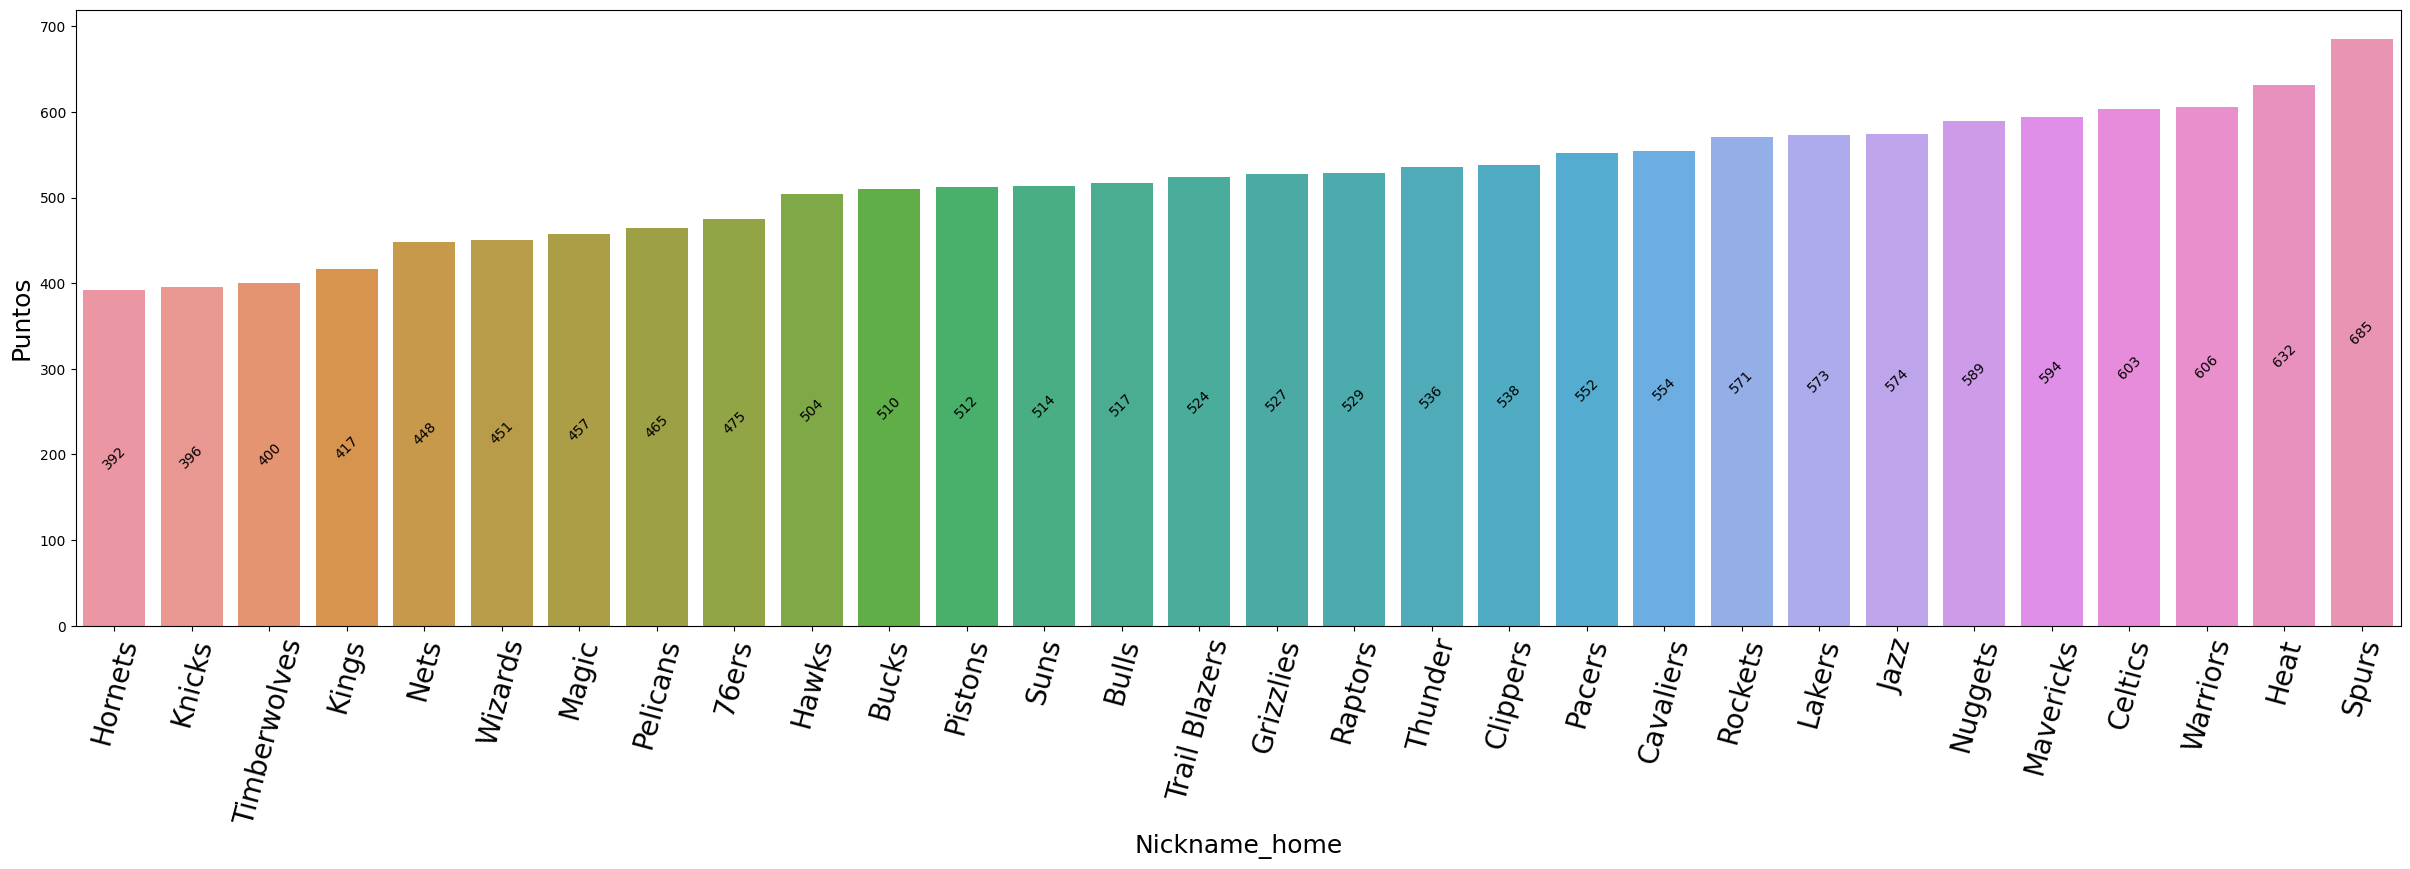

In [28]:
#Hacemos un gráfico para saber qué cantidad de partidos gano un equipo de local
plt.figure(figsize=(30,8))
result = home_wins['nickname_home'].value_counts().sort_values()
ax = sns.countplot(x='nickname_home', data=home_wins, order=result.index)
ax.bar_label(ax.containers[-1], label_type='center', rotation=45)
plt.xticks(rotation=75, fontsize=20)
plt.xlabel('Nickname_home', fontsize=18) 
plt.ylabel('Puntos', fontsize=18) 
plt.xticks(rotation=75)
plt.show()

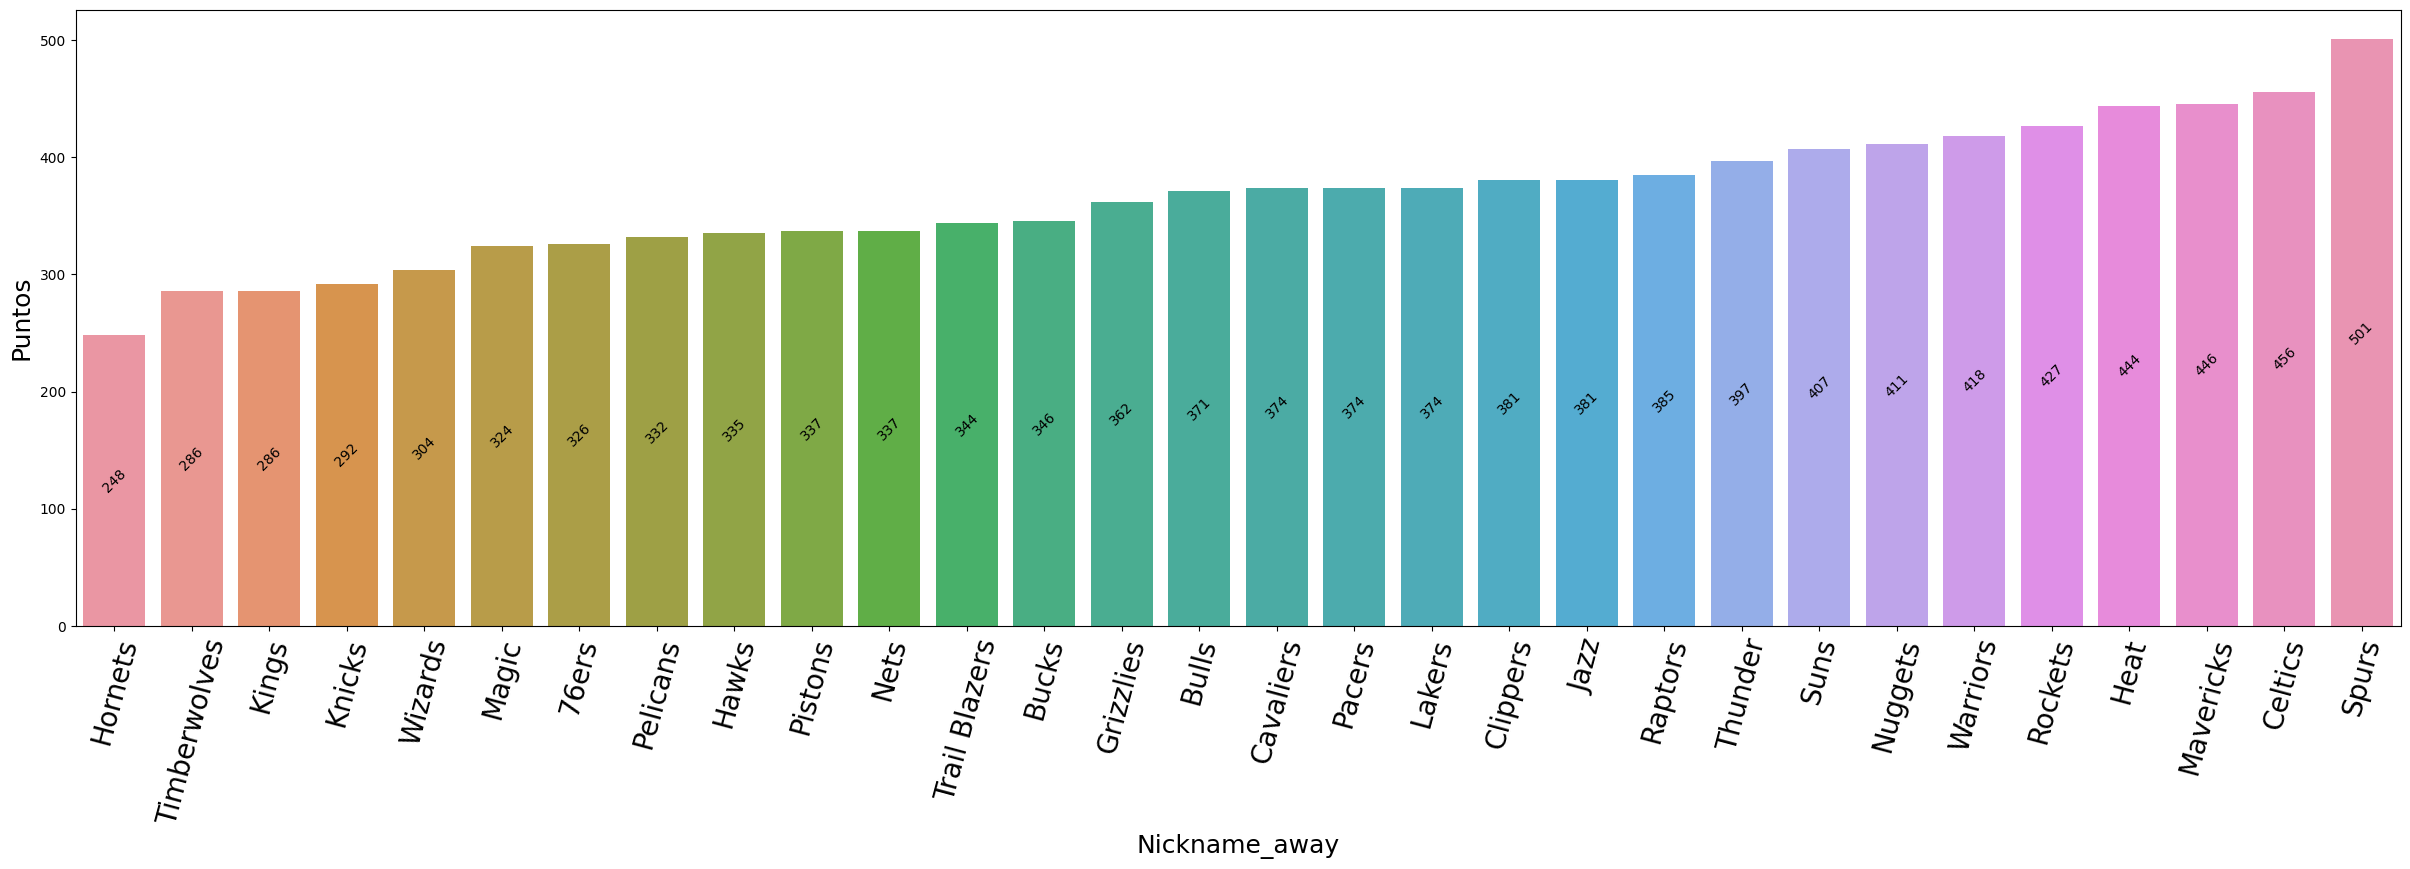

In [29]:
#Hacemos un gráfico para saber qué cantidad de partidos gano un equipo de visitante
plt.figure(figsize=(30,8))
result = away_wins['nickname_away'].value_counts().sort_values()
ax = sns.countplot(x='nickname_away', data=away_wins, order=result.index)
ax.bar_label(ax.containers[-1], label_type='center', rotation=45)
plt.xticks(rotation=75, fontsize=20)
plt.xlabel('Nickname_away', fontsize=18) 
plt.ylabel('Puntos', fontsize=18) 
plt.xticks(rotation=75)
plt.show()

In [31]:
#Analizamos cuantos puntos se hicieron a lo largo de los años

games.groupby('year')['total_points'].mean()


year
2003    184.475269
2004    188.379151
2005    193.944251
2006    195.553411
2007    196.871795
2008    198.470180
2009    200.169468
2010    199.734637
2011    197.679781
2012    192.825949
2013    197.085196
2014    201.815406
2015    200.326991
2016    207.307908
2017    211.543402
2018    216.689580
2019    221.965465
2020    224.262899
2021    221.128160
2022    224.392377
Name: total_points, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


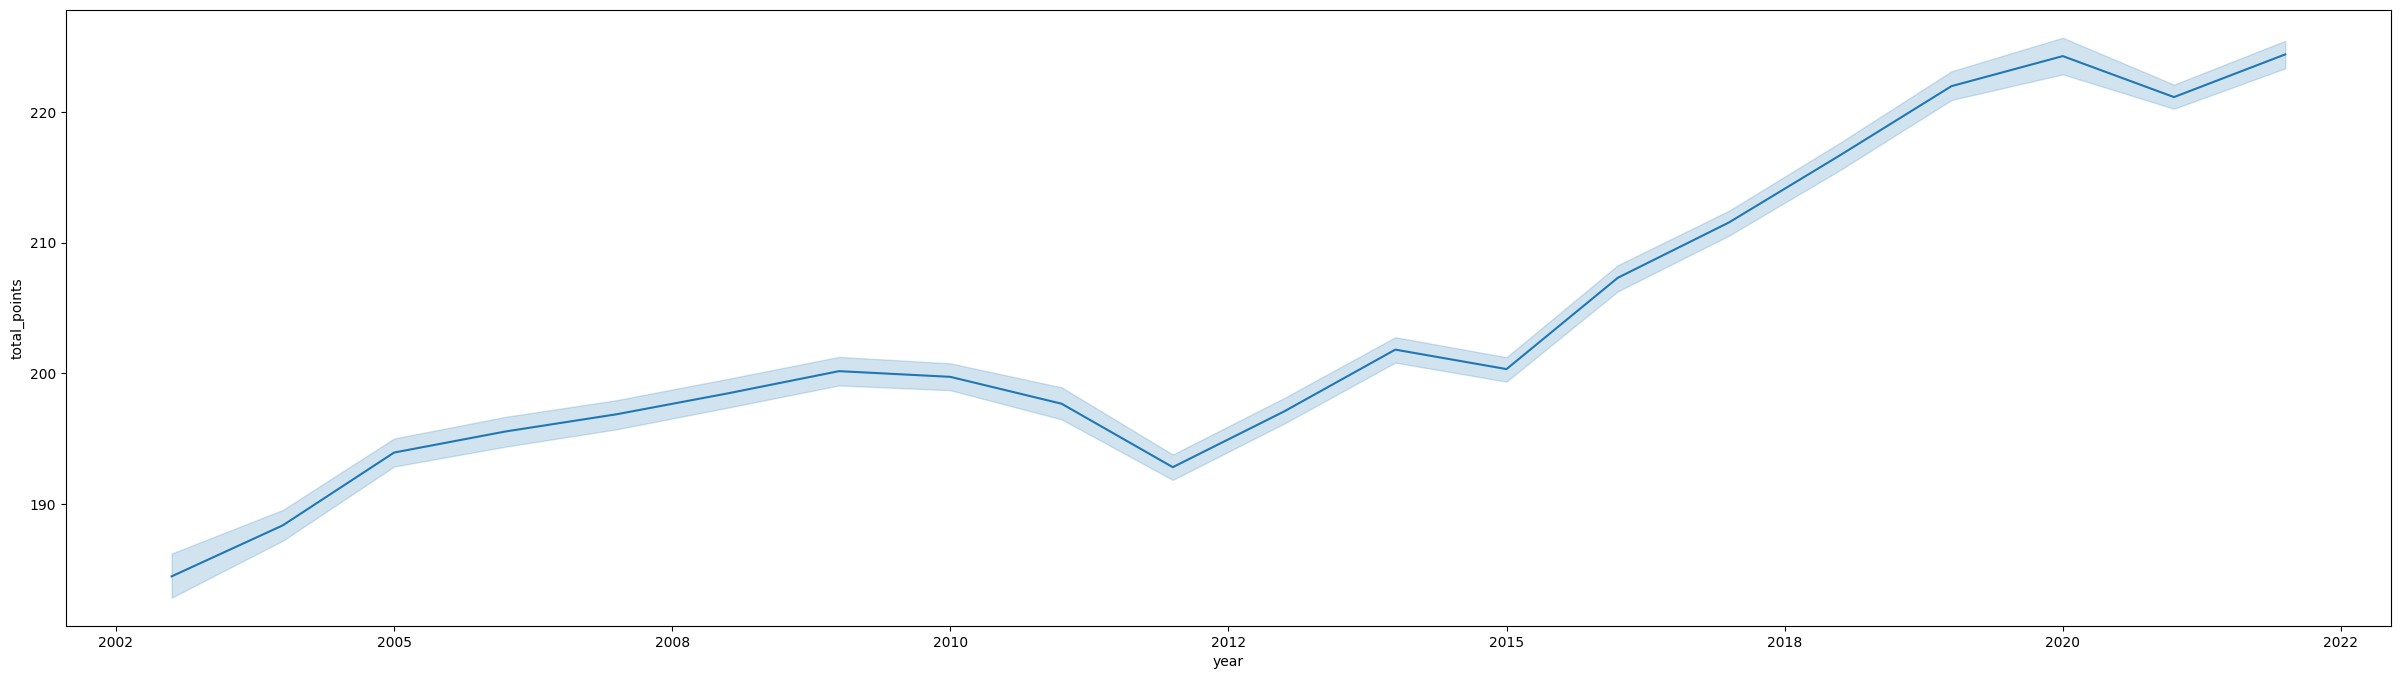

In [37]:
#Hacemos el gráfico para mostrar los puntos que se hicieron a lo largo de los años
plt.figure(figsize=(30,8))
ax = sns.lineplot(data=games, x='year', y='total_points')

def format_xlabels(value,pos):
    return str(int(round(value)))

ax.xaxis.set_major_formatter(plt.FuncFormatter(format_xlabels))

plt.show()

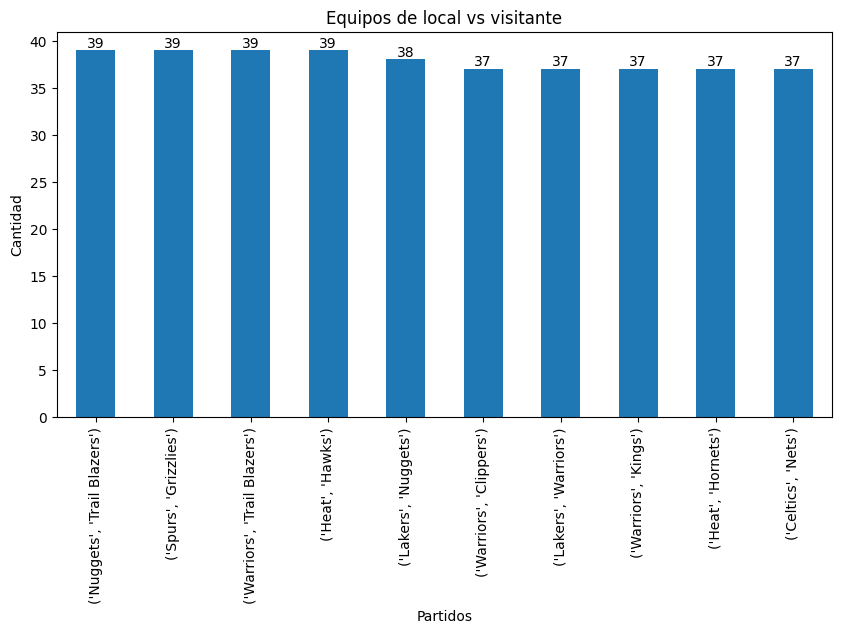

In [43]:
#Gráfico para conocer qué equipos le ganan más a otros de local. Por ejemplo, los Nuggets le ganan más a los Trail Blazers 
#cuando juegan de local.

x = home_wins[['nickname_home','nickname_away']].value_counts()
ax = x[:10].plot(kind="bar", figsize=[10,5]) #me quedo con los 10 primeros
ax.set_title('Equipos de local vs visitante')
ax.set_xlabel('Partidos')
ax.set_ylabel('Cantidad')
ax.set_xticklabels(x.index[:10], rotation=90)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+p.get_width()/2, p.get_height()), ha='center', va='bottom')

plt.show()

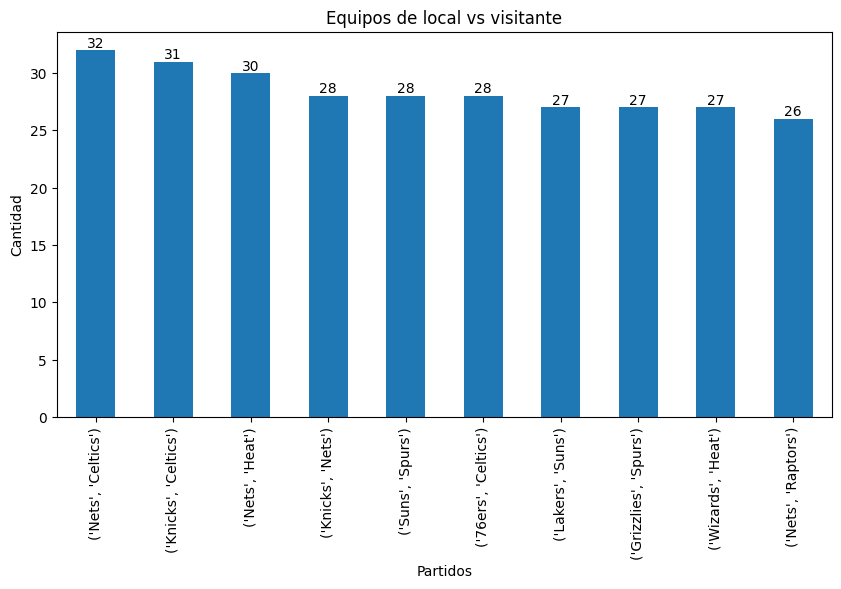

In [44]:
_#Gráfico para conocer qué equipos le ganan más a otros de visitante. Por ejemplo, los Celtics le ganan más a los Nets
#cuando juegan de visitante.

x = away_wins[['nickname_home','nickname_away']].value_counts()
ax = x[:10].plot(kind="bar", figsize=[10,5]) #me quedo con los 10 primeros
ax.set_title('Equipos de local vs visitante')
ax.set_xlabel('Partidos')
ax.set_ylabel('Cantidad')
ax.set_xticklabels(x.index[:10], rotation=90)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+p.get_width()/2, p.get_height()), ha='center', va='bottom')

plt.show()

In [46]:
#Leemos el archivo que contiene más datos sobre los jugadores y los partidos
game_details = pd.read_csv('/kaggle/input/nba-games/games_details.csv')
game_details.head()

/tmp/ipykernel_33/1056212354.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  game_details = pd.read_csv('/kaggle/input/nba-games/games_details.csv')


,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,22200477,1610612759,SAS,San Antonio,1629641,Romeo Langford,Romeo,F,NaN,18:06,...,1.0,1.0,2.0,0.0,1.0,0.0,2.0,5.0,2.0,-2.0
1,22200477,1610612759,SAS,San Antonio,1631110,Jeremy Sochan,Jeremy,F,NaN,31:01,...,6.0,3.0,9.0,6.0,1.0,0.0,2.0,1.0,23.0,-14.0
2,22200477,1610612759,SAS,San Antonio,1627751,Jakob Poeltl,Jakob,C,NaN,21:42,...,1.0,3.0,4.0,1.0,1.0,0.0,2.0,4.0,13.0,-4.0
3,22200477,1610612759,SAS,San Antonio,1630170,Devin Vassell,Devin,G,NaN,30:20,...,0.0,9.0,9.0,5.0,3.0,0.0,2.0,1.0,10.0,-18.0
4,22200477,1610612759,SAS,San Antonio,1630200,Tre Jones,Tre,G,NaN,27:44,...,0.0,2.0,2.0,3.0,0.0,0.0,2.0,2.0,19.0,0.0


In [ ]:
#Para saber qué jugador hizo más puntos en el año 2022 agrupo los datos
game_details = game_details[['GAME_ID', 'PLAYER_NAME', 'PTS']]

In [47]:
#Hago un merge para unir y filtrar en los conjuntos de datos y me traigo los nombres de los jugadores y los puntos que hicieron
#por equipo
games_complete = pd.merge(game_details, games, left_on='GAME_ID', right_on='game_id', how='inner')
games_complete.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,...,pts_home,pts_away,home_team_wins,year,team_id,city_home,nickname_home,city_away,nickname_away,total_points
0,22200477,1610612759,SAS,San Antonio,1629641,Romeo Langford,Romeo,F,NaN,18:06,...,126.0,117.0,1,2022,1610612740,New Orleans,Pelicans,San Antonio,Spurs,243.0
1,22200477,1610612759,SAS,San Antonio,1631110,Jeremy Sochan,Jeremy,F,NaN,31:01,...,126.0,117.0,1,2022,1610612740,New Orleans,Pelicans,San Antonio,Spurs,243.0
2,22200477,1610612759,SAS,San Antonio,1627751,Jakob Poeltl,Jakob,C,NaN,21:42,...,126.0,117.0,1,2022,1610612740,New Orleans,Pelicans,San Antonio,Spurs,243.0
3,22200477,1610612759,SAS,San Antonio,1630170,Devin Vassell,Devin,G,NaN,30:20,...,126.0,117.0,1,2022,1610612740,New Orleans,Pelicans,San Antonio,Spurs,243.0
4,22200477,1610612759,SAS,San Antonio,1630200,Tre Jones,Tre,G,NaN,27:44,...,126.0,117.0,1,2022,1610612740,New Orleans,Pelicans,San Antonio,Spurs,243.0


In [51]:
#Me fijo los 10 jugadores que más puntos hicieron en 2022
player_pts = games_complete.groupby(['year', 'PLAYER_NAME'])['PTS'].mean().reset_index().sort_values('year')
player_pts[player_pts['year'] == 2022].sort_values(by='PTS', ascending=False).head(10)


,year,PLAYER_NAME,PTS
11862,2022,Giannis Antetokounmpo,31.358974
11978,2022,Joel Embiid,31.166667
12094,2022,Luka Doncic,30.644444
12266,2022,Shai Gilgeous-Alexander,29.074074
12050,2022,Kevin Durant,29.029851
12081,2022,LeBron James,28.741379
11899,2022,Ja Morant,28.000000
11960,2022,Jayson Tatum,27.880000
11799,2022,Devin Booker,27.750000
12306,2022,Trae Young,27.333333
